In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [3]:
def loadSeries(datatype=None,house=None,rename=None, shifts=None):
    '''
    Loading data series from cf_filled (consumption) or pf_filled (production)
    
    datatype: str, specifies whether the production or consumption values are selected
              
              "Production", "Consumption", "P", "C", "prod", "cons", etc.
    
    
    house: str, specifies which house is selected 
           
           "k28", "h16", "h22", "h28", or "h32"
         
    rename: str, renames chosen column. 
            
            If the whole file is returned, this parameter is ignored
            
    shifts: list of int, if given, specifies what shifted columns to add
    '''
    res = None
    #Production or consumption string stuff
    datatypeStr = ""
    if datatype is None:
        raise Exception("First input must specify either Production or Consumption")
    elif datatype[0].lower()=="p":
        datatypeStr = "prod_"
    elif datatype[0].lower()=="c":
        datatypeStr = "cons_"
    
    #Making sure an existing house is chosen
    if house is None:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    
    #Production or consumption is chosen and loaded
    if datatypeStr=="prod_":
        res = pd.read_csv("pf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    else:
        res = pd.read_csv("cf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    
    #Renaming value column
    if not house is None and not rename is None:
        res = res.rename(columns={datatypeStr+house: rename}, errors="raise")
    
    #Shifted columns added
    if not shifts is None:
        if rename is None:
            shiftname = 't'
        else:
            shiftname = rename
        dataframe = pd.DataFrame()
        for i in shifts:
           dataframe[shiftname + '-' + str(i)] = res.shift(i)
        res = pd.concat([res, dataframe], axis=1)
        res.dropna(inplace=True)
    
    #Nice stuff for indexing
    res['Year']=res.index.year
    res['Month']=res.index.month
    res['Day']=res.index.day
    res['Weekday']=res.index.weekday
    res['Hour']=res.index.hour
    return res

def moving_average(timeseries, window):
    return timeseries.rolling(window=window, center=True).mean()

In [28]:
def merge(house=None,names=["prod","cons"]):
    if house is None:
        raise Exception("First input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("First input must specify house: k28, h16, h22, h28, or h32")
    
    if names is None or len(names)!=2:
        raise Exception("Second input must be a string list of len 2: names=['prod','cons']")
    production = loadSeries("p",house,names[0])['prod']
    consumption = loadSeries("c",house,names[1])['cons']
    merged = pd.merge(production, consumption, how="outer", left_index=True,right_index=True)
    merged["power_yield"] = merged[names[0]] - merged[names[1]]
    merged["timeslot"] = merged.index
    return merged
house = "h16"
merged = merge(house)
merged

,prod,cons,power_yield,timeslot
2020-12-22 00:00:00+00:00,0.0,6.3,-6.3,2020-12-22 00:00:00+00:00
2020-12-22 01:00:00+00:00,0.0,4.8,-4.8,2020-12-22 01:00:00+00:00
2020-12-22 02:00:00+00:00,0.0,4.8,-4.8,2020-12-22 02:00:00+00:00
2020-12-22 03:00:00+00:00,0.0,4.3,-4.3,2020-12-22 03:00:00+00:00
2020-12-22 04:00:00+00:00,0.0,4.0,-4.0,2020-12-22 04:00:00+00:00
...,...,...,...,...
2023-01-10 16:00:00+00:00,0.3,6.1,-5.8,2023-01-10 16:00:00+00:00
2023-01-10 17:00:00+00:00,0.0,8.3,-8.3,2023-01-10 17:00:00+00:00
2023-01-10 18:00:00+00:00,0.0,10.4,-10.4,2023-01-10 18:00:00+00:00
2023-01-10 19:00:00+00:00,0.0,9.9,-9.9,2023-01-10 19:00:00+00:00


In [35]:
class Battery():
    def __init__(self, max_capacity = 13.5, current_capacity = 0, surplus_deficit = 0, max_charge = 7) -> None:
        self.max_capacity = max_capacity
        self.current_capacity = current_capacity
        self.surplus_deficit = surplus_deficit
        self.charge_list = []
        self.discharge_list = []
        self.max_charge = max_charge

    def charge(self, amount: float, degrade: bool) -> float:
        if degrade:
            self.degrade(1)
        
        if amount >= self.max_charge:
            extra_amount = amount - self.max_charge
            amount = self.max_charge
            self.charge_list.append(amount)
            self.discharge_list.append(0)

        # If discharge amount is larger than max_charge
        elif amount <= -self.max_charge:
            extra_amount = self.max_charge + amount
            amount = -self.max_charge
            self.discharge_list.append(amount)
            self.charge_list.append(0)

        else:
            extra_amount = 0
            self.discharge_list.append(0)
            self.charge_list.append(0)

        self.current_capacity += amount
        self.surplus_deficit = extra_amount

        
        # We charge the battery
        if self.current_capacity >= self.max_capacity:
            self.surplus_deficit += self.current_capacity - self.max_capacity
            self.current_capacity = self.max_capacity

        # We discharge the battery
        elif self.current_capacity <= 0:
            # Return the amount of energy that was not discharged
            self.surplus_deficit += self.current_capacity
            self.current_capacity = 0
        
    
    def degrade(self, hours):
        rate = 0.05 # %/h
        self.current_capacity -= self.current_capacity * rate * hours
    
    def get_surplus_deficit(self) -> float:
        return self.surplus_deficit
    
    def get_current_capacity(self) -> float:
        return self.current_capacity
    
    def get_max_capacity(self) -> float:
        return self.max_capacity
    
    def get_percentage(self) -> float:
        return self.current_capacity / self.max_capacity * 100
    
    def __str__(self):
        return f"Capacity: {self.current_capacity}, Surplus: {self.surplus_deficit}"

In [36]:
#Small test
y = merged[100:110]['prod']

bat = Battery()

for val in y:
    print(val)
    bat.charge(val,True)
    print(bat)
    print()

0.0
Capacity: 0, Surplus: 0.0

0.1000000000058207
Capacity: 0.1000000000058207, Surplus: 0

0.0
Capacity: 0.09500000000552966, Surplus: 0

0.0
Capacity: 0.09025000000525318, Surplus: 0

0.0
Capacity: 0.08573750000499053, Surplus: 0

0.0
Capacity: 0.081450625004741, Surplus: 0

0.0999999999912688
Capacity: 0.17737809374577274, Surplus: 0

0.5
Capacity: 0.6685091890584841, Surplus: 0

0.9000000000087311
Capacity: 1.535083729614291, Surplus: 0

1.0
Capacity: 2.4583295431335763, Surplus: 0



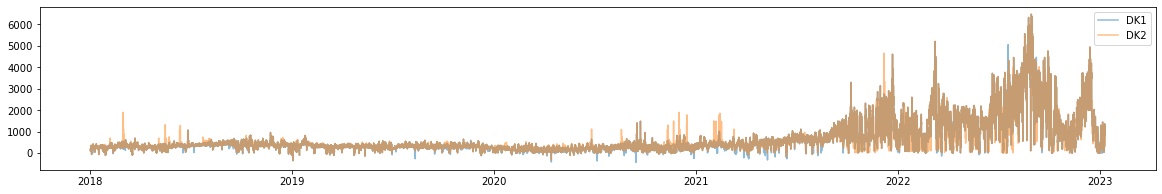

In [37]:
el = pd.read_csv('Elspotprices.csv', sep=';', decimal=',')
el = el.drop(['HourUTC','SpotPriceEUR'],axis=1)
el['HourDK'] = pd.to_datetime(el['HourDK'])
el = el.set_index('HourDK')

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(el[el['PriceArea']=='DK1']['SpotPriceDKK'],label='DK1',alpha=0.5)
plt.plot(el[el['PriceArea']=='DK2']['SpotPriceDKK'],label='DK2',alpha=0.5)
plt.legend()
plt.show()

In [54]:
def logic_rollout(series_battery, battery, logic, get_price):
    """Battery logic rollout

    Args:
        series_battery (DataFrame): time series of battery
        battery (object): Battery object 
        logic (funct): Logic function applied to the row
        get_price (funct): Get price function

    Returns:
        DataFrame: Time series datafram with applied logic and price
    """
    series_battery = series_battery.apply(lambda row: logic(row, battery), axis=1)
    series_battery["price"] = series_battery.apply(lambda row: get_price(row["surplus_deficit"], row["timeslot"]), axis=1)
    series_battery["price_cummulative"] = series_battery["price"].cumsum(axis=0)
    return series_battery


# Definge get price function   
def get_price(demand, timestamp):
    """Get price function

    Args:
        demand (float): Power demand
        hour (int): Hour of the day to make price lookup

    Returns:
        float: Price 
    """

    # Update hour_lookup_price by multiplying peak_hours by 8
    # for key, value in hour_lookup_price.items():
    #     if int(key) in peak_hours:
    #         hour_lookup_price[key] = value * 1.8

    if demand >= 0:
        # Selling price 
        return -demand * el['SpotPriceDKK'][timestamp][1]
        # For leap year, assume that day 366 of year is 365
    else:
        # Buying price
        return -demand * el['SpotPriceDKK'][timestamp][0]


def print_price_summary(series_battery):
    start, end = series_battery["timeslot"].iloc[0], series_battery["timeslot"].iloc[-1]
    difference_in_years = relativedelta(end, start).years
    print(f"Cost for period: {start} to {end} is: ", round(series_battery["price"].sum(), 0), " DKK")
    num_wh_total = series_battery[series_battery["surplus_deficit"] < 0]["surplus_deficit"].sum() 
    num_wh_total_sold = series_battery[series_battery["surplus_deficit"] > 0]["surplus_deficit"].sum() 

    time_delta_seconds =  (end-start).total_seconds()
    years_timedelta = time_delta_seconds/(365.25*24*60*60)
    print(f"Average cost per year is: {round(series_battery['price'].sum()/years_timedelta,0)} DKK")

    print(f"Number of kwh purchased in the period: {-num_wh_total}")

    print(f"Average number of kwh purchased per year: {-num_wh_total/years_timedelta}")
       
    print(f"Average number of kwh sold per year: {num_wh_total_sold/years_timedelta}")


    return round(series_battery['price'].sum()/years_timedelta,0),-num_wh_total/years_timedelta, num_wh_total_sold/years_timedelta


In [ ]:
avg_yearly_cost_dict = {}

In [55]:
# Define battery with capcacity 0, same as no battery
battery = Battery(max_capacity=0)

# Define logic, in this case it does nothing
def logic(row, battery):
    power_yield = row["power_yield"]
    battery.charge(power_yield,True)

    row["battery_capacity"] = battery.get_current_capacity()
    row["surplus_deficit"] = battery.get_surplus_deficit()
    row["charge"] = battery.charge_list[-1]
    row["discharge"] = battery.discharge_list[-1]

    return row

series_no_battery = logic_rollout(merged[:300].copy(), battery, logic, get_price)

avg_yearly_cost_dict["No battery"] = (print_price_summary(series_no_battery), sum(battery.charge_list), sum(battery.discharge_list))

C:\Users\alexa\AppData\Local\Temp\ipykernel_16472\1697515037.py:42: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return -demand * el['SpotPriceDKK'][timestamp][0]
C:\Users\alexa\AppData\Local\Temp\ipykernel_16472\1697515037.py:38: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return -demand * el['SpotPriceDKK'][timestamp][1]


Cost for period: 2020-12-22 00:00:00+00:00 to 2021-01-03 11:00:00+00:00 is:  578398.0  DKK
Average cost per year is: 16957304.0 DKK
Number of kwh purchased in the period: 2231.499999999971
Average number of kwh purchased per year: 65422.50501672156
Average number of kwh sold per year: 331.2903010025766


In [56]:
simple_logic_capacity = 13
# Define battery with capcacity
battery = Battery(max_capacity=simple_logic_capacity)

# Define logic charge/discharge battery if needed
def logic(row, battery):
    power_yield = row["power_yield"]
    battery.charge(power_yield,True)

    row["battery_capacity"] = battery.get_current_capacity()
    row["surplus_deficit"] = battery.get_surplus_deficit()
    row["charge"] = battery.charge_list[-1]
    row["discharge"] = battery.discharge_list[-1]
    return row

series_battery = logic_rollout(merged[:300].copy(), battery, logic, get_price)

avg_yearly_cost_dict["Simple logic"] = (print_price_summary(series_battery), sum(battery.charge_list), sum(battery.discharge_list))

C:\Users\alexa\AppData\Local\Temp\ipykernel_16472\1697515037.py:42: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return -demand * el['SpotPriceDKK'][timestamp][0]
C:\Users\alexa\AppData\Local\Temp\ipykernel_16472\1697515037.py:38: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return -demand * el['SpotPriceDKK'][timestamp][1]


Cost for period: 2020-12-22 00:00:00+00:00 to 2021-01-03 11:00:00+00:00 is:  578173.0  DKK
Average cost per year is: 16950712.0 DKK
Number of kwh purchased in the period: 2221.5199881249946
Average number of kwh purchased per year: 65129.913765564226
Average number of kwh sold per year: 0.0
